<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/ImageDataGenerator_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import random
import shutil
import tensorflow as tf
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-03-17 16:16:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.252.210, 2600:1413:1:597::317f, 2600:1413:1:5a0::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.252.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   126MB/s    in 5.7s    

2023-03-17 16:17:02 (139 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
!ls /tmp

 cats-and-dogs.zip
 CDLA-Permissive-2.0.pdf
 dap_multiplexer.8eabe52fde40.root.log.INFO.20230317-161412.95
 dap_multiplexer.INFO
 debugger_140ek4xfwu
 initgoogle_syslog_dir.0
 kernel_manager_proxy.8eabe52fde40.root.log.INFO.20230317-161407.21
 kernel_manager_proxy.8eabe52fde40.root.log.WARNING.20230317-161413.21
 kernel_manager_proxy.INFO
 kernel_manager_proxy.WARNING
 PetImages
 pyright-794-3I0AYnasfm0V
 pyright-794-yYvSAEhBhTP6
 python-languageserver-cancellation
'readme[1].txt'


In [4]:
source_dir = '/tmp/PetImages'
source_dir_dogs = os.path.join(source_dir, 'Dog')
source_dir_cats = os.path.join(source_dir, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

print(f"There are {len(os.listdir(source_dir_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_dir_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


## Organise directories in preparation for ImageDataGenerator

In [5]:
def create_train_and_val_dirs(root_dir):
  os.makedirs(os.path.join(root_dir, 'training'))
  os.makedirs(os.path.join(root_dir, 'validation'))

  os.makedirs(os.path.join(root_dir, 'training', 'cats'))
  os.makedirs(os.path.join(root_dir, 'training', 'dogs'))
  os.makedirs(os.path.join(root_dir, 'validation', 'cats'))
  os.makedirs(os.path.join(root_dir, 'validation', 'dogs'))


root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError if running this multiple times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

create_train_and_val_dirs(root_dir)

In [6]:
!ls /tmp/cats-v-dogs


training  validation


In [7]:
def split_data(source_dir, training_dir, validation_dir, split_size):
  source_imgs = os.listdir(source_dir)

  # Remove zero-length images from the source first
  zero_imgs = []
  for img in source_imgs:
    if not os.path.getsize(os.path.join(source_dir, img)):
      print(f'{img} is zero length, so ignoring.')
      zero_imgs.append(img)
  source_imgs = list(set(source_imgs) - set(zero_imgs))

  training_size = int(len(source_imgs) * split_size)
  training_imgs = random.sample(source_imgs, training_size)

  for img in source_imgs:
    if img in training_imgs:
      destination = os.path.join(training_dir, img)
    else:
      destination = os.path.join(validation_dir, img)
    copyfile(os.path.join(source_dir, img), destination)

split_size = 0.9

training_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

# Create cats directories for training and validation
training_cats_dir = os.path.join(root_dir, 'training', 'cats')
validation_cats_dir = os.path.join(root_dir, 'validation', 'cats')
split_data(source_dir_cats, training_cats_dir, validation_cats_dir, split_size)

# Create dogs directories for training and validation
training_dogs_dir = os.path.join(root_dir, 'training', 'dogs')
validation_dogs_dir = os.path.join(root_dir, 'validation', 'dogs')
split_data(source_dir_dogs, training_dogs_dir, validation_dogs_dir, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


## Creating the model

In [8]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

In [9]:
def create_model(input_shape=(150, 150, 3),
                 loss_function='binary_crossentropy',
                 learning_rate=0.001,
                 metrics=['accuracy']):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss=loss_function,
                  optimizer=RMSprop(learning_rate),
                  metrics=metrics)
    
    return model

## Image Preprocessing with Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rescale=(1./255),
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=(1./255))

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Training

In [11]:
EPOCHS = 16

In [12]:
model = create_model()

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/16
100/100 - 29s - loss: 0.7897 - accuracy: 0.5070 - val_loss: 0.6974 - val_accuracy: 0.5230 - 29s/epoch - 295ms/step
Epoch 2/16
100/100 - 19s - loss: 0.6953 - accuracy: 0.5055 - val_loss: 0.6904 - val_accuracy: 0.5570 - 19s/epoch - 187ms/step
Epoch 3/16
100/100 - 20s - loss: 0.6899 - accuracy: 0.5485 - val_loss: 0.6673 - val_accuracy: 0.5880 - 20s/epoch - 202ms/step
Epoch 4/16
100/100 - 20s - loss: 0.6852 - accuracy: 0.5640 - val_loss: 0.6549 - val_accuracy: 0.6410 - 20s/epoch - 203ms/step
Epoch 5/16
100/100 - 20s - loss: 0.6581 - accuracy: 0.6230 - val_loss: 0.6122 - val_accuracy: 0.6740 - 20s/epoch - 197ms/step
Epoch 6/16
100/100 - 20s - loss: 0.6397 - accuracy: 0.6340 - val_loss: 0.5897 - val_accuracy: 0.6870 - 20s/epoch - 199ms/step
Epoch 7/16
100/100 - 20s - loss: 0.6274 - accuracy: 0.6441 - val_loss: 0.6027 - val_accuracy: 0.6330 - 20s/epoch - 201ms/step
Epoch 8/16
100/100 - 20s - loss: 0.6281 - accuracy: 0.6480 - val_loss: 0.5983 - val_accuracy: 0.6890 - 20s/epoch - 203

In [13]:
def plot_loss_acc(history):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(train_acc))

  plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

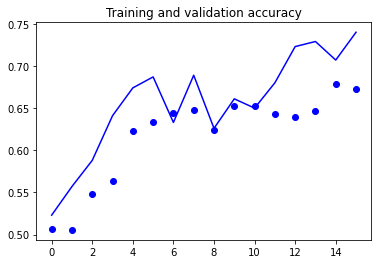

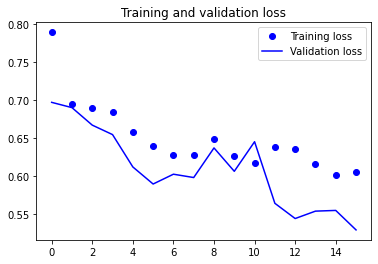

In [14]:
plot_loss_acc(history)